Convolutional Neural Networks
====

Summary:
- Understand the underlying motivations for convolutional networks
- Create your own convolutional network in PyTorch
- Train it on CIFAR data
- Improve the training of your own network
- Perform an hyperparameter search

We fix the random seed to make things easier to debug.

Motivation
---

__Dataset__

We consider images from the CIFAR10 dataset. It consists in 50,000 images of size 32x32, split across 10 classes. We load the train and the test set whithout forgetting to normalize the images by their per-channel mean and standard deviation. What is the batch size for train and test?

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(0)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# image = (image - mean) / std for each chanel

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's have a look at the first image. What is the size of the image? What does the first dimension represent? Can you display its label (an integer between 0 and 9)? Can you display its class?

In [ ]:
batch, targets = iter(trainloader).next()
batch.size(), targets.size()

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [ ]:
batch, targets = iter(trainloader).next()
image, target = batch[0], targets[0]
print(image.size(), target, classes[target.item()])
# Size of the image: (3, 32, 32)
# Label of the image: 0
# Class of the image: plane 

torch.Size([3, 32, 32]) tensor(0) plane


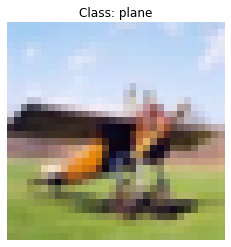

In [ ]:
import matplotlib.pyplot as plt


def display(image, title):
    image = image.permute(1, 2, 0)  # image of size (32, 32, 3)
    image -= image.min()
    image /= image.max()
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.title(title)
    plt.show()
    
# display the image
display(image, f"Class: {classes[target]}")

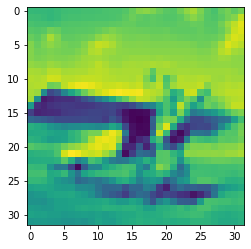

In [ ]:
plt.imshow(image[0])

In [ ]:
batch[0].shape,targets[5].item(),classes[targets[5].item()]

(torch.Size([3, 32, 32]), 1, 'car')

__2D Convolutions__

Say you want to learn a network to classify the images into the 10 classes. It will output a vector of probabilities of size 10 for each image of size `3 x 32 x 32`. First let's consider a simple fully-connected network.

In [ ]:
import torch.nn as nn


class FullyConnectedNetwork(nn.Module):
    
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 3*32*32)
        self.fc2 = nn.Linear(3*32*32, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    

fully_connected = FullyConnectedNetwork()

What are the two main disadvantages of using a single fully-connected linear layer (squared) followed by a classifier?
 
First disadvantage: a fully connected layer will take a lot of parameters! Can you compute the size of the network?

In [ ]:
sum = 0
for name, param in fully_connected.named_parameters():
  # how do I update sum here?
  sum += param.numel()
print(f"Total number of parameters: {sum}")

Total number of parameters: 9470986


In [ ]:
# what is the size of the network, in MB, on disk, assuming fp32 numbers?
# 1 fp32 number is stored in 32 bits = 4 bytes
# 1 bit = 0 or 1 
# 1 byte = 8 bits 
# 32 bits = 4 bytes 

print(f"Size of the network = {sum * 4 / 1024 / 1024:.0f} MB")

Size of the network = 36 MB


In [ ]:
# compute number of parameters / size in KB

Second disadvantage: the fully connected layer does not take the structure of the image into account. Nearby pixels are highly correlated. 

That's why we will use convolutions.In the next illustration, we consider a 2D convolution.
- The blue image is called the _input_ image
- The green image is called the _output_ image 
- The convolutional filter has a size `3x3` that is called the _kernel size_

Here, convolutions are performed by successively considering areas of size `3x3` and applying the kernel to it. Applying the kernel consists in summing the element-wise product of the kernel and the input image area to get a single output number.

In [ ]:
from IPython.display import HTML
HTML('<img src="https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif">')

Let's consider a very simple kernel. Can you compute by hand the result of the convolution of the kernel by the input matrix? What is the size of the resulting output matrix?

In [ ]:
import torch.nn.functional as F


kernel = torch.Tensor([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])

input_matrix = torch.Tensor([
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 2, 1, 0],
    [0, 0, 0, 0, 3],
    [0, 0, 0, 1, 0],
])

# if we use a kernel of size 2x2, what's the output size?

# step 1:
# kernel sees 
# [0, 0, 0]
# [0, 1, 0]
# [0, 0 ,2]
# result = 6

# step 1:
# kernel sees 
# [0, 0, 1]
# [1, 0, 1]
# [0, 2, 1]
# result = 10

print('Kernel')
print(kernel)
print('Input matrix')
print(input_matrix)
print('Output matrix')
print(F.conv2d(input_matrix.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0)))

Kernel
tensor([[1., 2., 1.],
        [2., 4., 2.],
        [1., 2., 1.]])
Input matrix
tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 2., 1., 0.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 1., 0.]])
Output matrix
tensor([[[[ 6., 10., 10.],
          [ 6., 12., 13.],
          [ 2.,  6., 12.]]]])


Now let's add some padding! It consists in adding zeros at each border of the image. What is the result? What is the size of the resulting image?

In [ ]:
kernel = torch.Tensor([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])

input_matrix = torch.Tensor([
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 2, 1, 0],
    [0, 0, 0, 0, 3],
    [0, 0, 0, 1, 0],
])
# input matrix is 5x5. when padded, it's 7x7. Output would be 5x5

input_matrix_padded = torch.Tensor([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 2, 1, 0, 0],
    [0, 0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
])

print('Kernel')
print(kernel)
print('Input matrix')
print(input_matrix)
print('Padded input matrix')
print(F.pad(input_matrix, (1, 1, 1, 1)))
print('Output matrix')
print(F.conv2d(input_matrix.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=(1,1)))

Kernel
tensor([[1., 2., 1.],
        [2., 4., 2.],
        [1., 2., 1.]])
Input matrix
tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 2., 1., 0.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 1., 0.]])
Padded input matrix
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 2., 1., 0., 0.],
        [0., 0., 0., 0., 0., 3., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])
Output matrix
tensor([[[[ 1.,  2.,  4.,  6.,  3.],
          [ 2.,  6., 10., 10.,  4.],
          [ 1.,  6., 12., 13.,  9.],
          [ 0.,  2.,  6., 12., 14.],
          [ 0.,  0.,  2.,  7.,  8.]]]])


Convolutions can help in a lot of ways! Let's consider three particular kernels and apply it on an image. Can you write the code to do it? What is the effect? What is the first kernel doing? The second one? Why? Can you change the second kernel to get the vertical edges? What os the mystery kernel doing?

In [ ]:
import torch.nn.functional as F


def apply_conv(image, kernel):
    return F.conv2d(torch.Tensor(image).unsqueeze(0).unsqueeze(0), 
                    kernel.unsqueeze(0).unsqueeze(0)).squeeze().numpy()

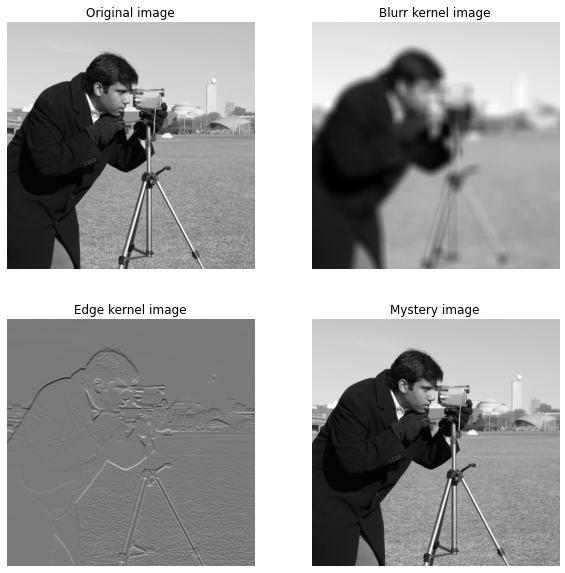

In [ ]:
from skimage import data, img_as_float


blurr_kernel =  1 / 100 * torch.ones(10, 10)
blurr_kernel =  1 / 25 * torch.ones(5, 5)
blurr_kernel =  1 / (20*20) * torch.ones(20, 20)
edge_kernel =  torch.Tensor([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]])
mystery_kernel = torch.Tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])


input_image = img_as_float(data.camera())
# compute the convolution of each kernel with input_image and apply_conv
blurr_image = apply_conv(input_image, blurr_kernel) 
edge_image = apply_conv(input_image, edge_kernel) 
mystery_image = apply_conv(input_image, mystery_kernel) 

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(input_image, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(222)
plt.imshow(blurr_image, cmap='gray')
plt.title('Blurr kernel image')
plt.axis('off')

plt.subplot(223)
plt.imshow(edge_image, cmap='gray')
plt.title('Edge kernel image')
plt.axis('off')

plt.subplot(224)
plt.imshow(mystery_image, cmap='gray')
plt.title('Mystery image')
plt.axis('off')

plt.show()

# what if the kernel has the size of the image?
# - output size -> 1x1
# - output value -> average pixel value

# what does the edge kernel do -> horizontal edge detection. Why?
# edge_kernel =  torch.Tensor([
#     [-1, -2, -1],
#     [0, 0, 0],
#     [1, 2, 1]])

# if the image is constant, what's the result -> 0
# if there is a sudden change (above is negative, below positive)

# what is the mystery kernel doing? Shift the image 

__3D convolutions__

3D convolutions work exactly the same as 2D convolutions, except that the convolutions operate on 3D tensors (like images) with 3D filters. 

<font color=blue>Important conventions of notation</font>:
- Image of size `C_in x H x W` (input channels x height x width)
- `C_out` (output channels) filters of size `C_in x k x k` (input channels x kernel size x kernel size)

In [ ]:
from IPython.display import HTML
HTML('<img src="https://predictiveprogrammer.com/wp-content/uploads/2018/06/convolve.gif">')

Question: with a kernel size of `k = 3` and a padding of `1`, if the input has size `C_in x H x W` and the filters have size `C_out x C_in x k x k`,  what is the size of the output?

It is `C_out x H x W`.

Define your own network
---

So far, we've understood how convolutions work and got a sense of their effectiveness (both in terms of parameters and ability to compute seemingly difficult operations such as detecting the edges). Now let's build a network!

The structure of the network is:

- Convolutional layer with 3 input filters, 32 output filters, kernel of size 5x5
- ReLU
- Convolutional layer with 32 input filters, 32 output filters, kernel of size 3x3
- ReLU
- Max pooling with kernel size 2x2
- Convolutional layer with 32 input filters, 64 output filters, kernel of size 3x3
- ReLU
- Convolutional layer with 64 input filters, 64 boutput filters, kernel of size 3x3
- ReLU
- Max pooling with kernel size 2x2
- Classifier of size ?? x 10 (you have to find the first dimension)


MaxPooling is taking the max along a receptive field of size `k x k` (see PyTorch documentation). To handle properly the Conv2d, see also PyTorch documentation. Print the sizes at each step, this will help you! Use `F.relu` for the ReLU!

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 3) 
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.pool1 = nn.MaxPool2d(3)
        self.pool2 = nn.MaxPool2d(4)
        self.fc = nn.Linear(64, 10) # <- what should we write there?
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  #F.relu is taking the relu
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        #print(x.size(), 'before last pool')
        x = self.pool2(x)
        # pool receives (batch_size, C, H, W)
        # pooling reduces the spatial (H, W) dimension of the image
        #print(x.size(), 'after last pool')
        # x size here is [1, 64, 1, 1]
        x = x.view(-1, 64) # why are we doing a x.view()
        # x size here is [1, 64]
        # self.fc needs input of size (batch_size, in_features)
        x = self.fc(x)
        
        return x
    
net = SimpleNet()  # instantiating the class, hence the network
# calls __init__()
print(net)

# test to pass
x = torch.rand(128, 3, 32, 32)
y = net(x)  # this should work!!! -> same as net.forward(x)
# what will be y.size() -> 128 x 10

SimpleNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
pool = nn.MaxPool2d(3)
x = torch.rand(4, 2, 6, 6)
pool(x).size()
# in a network, generally, going up:
# increase number of channels
# reduce spatial dimension

torch.Size([4, 2, 2, 2])


Can you forward an image to the network? What does it output? How many parameters does the network have? How does it compare with the parameters of the fully connected architecture decribed below? 

In [ ]:

net.parameters()

<generator object Module.parameters at 0x7f0318114d50>

In [ ]:
import numpy as np

# NEVER CALL A VARIABLE SUM 
# print number of parameters and compare it with the fully connected network!
sum_conv = np.sum([p.numel() for p in net.parameters()])
print(f"{sum_conv} parameters")
print(f"{sum_conv * 4 / 1024:.2f} KB disk size")

67754 parameters
264.66 KB disk size


Train your own network
---

One single pass over the whole training set is called an _epoch_. An epoch consists in iterations, each iteration corresponds to the pass of one single batch.

In [ ]:
import numpy as np


# top1 accuracy is the percentage of exact match between prediction and target
# top5 accuracy is the percentage of times the prediction is amont the t
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k)
        return np.sum(res)

# accuracy(outputs, targets), outputs.size(0)

In [ ]:
device = torch.device('cuda:1') 

In [ ]:
# x = torch.rand(10, 10).to(device)

In [ ]:
!nvidia-smi

Wed Mar 23 00:39:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
net = SimpleNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
device = torch.device('cuda:0')  # will give you the first available device

#TAKEAWAY:
# convs are efficient in terms of parameters
# convs are well suited for images (eg edge detection)
# fill out the trainng loop


# loop over the dataset multiple times
for epoch in range(15):
    print('Epoch: {}'.format(epoch))
    
    # train for 1 epoch on the train set
    correct = 0
    for i, (batch, targets) in enumerate(trainloader):
        
        # batch and targets to cuda 
        batch = batch.to(device)
        targets = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        outputs = net(batch)  # output = net.forward(batch)
        loss = criterion(outputs, targets)

        # backward
        loss.backward()

        # gradient step 
        optimizer.step()
        # can you write optimizer.step() explicitly, assuming plain SGD?
        # what is the SGD formula?
        # new_params = old_params - lr * gradient 
        # for p in net.parameters():
        #   p.data -= lr * p.grad
        # compute accuracy 
        correct += accuracy(outputs.cpu(), targets.cpu()).item()

    top_1 = correct / len(trainset) * 100
    print('Train accuracy: {:.2f}%'.format(top_1))
            
    # evaluate on the test set  
    with torch.no_grad():  # weights are fixed, no gradients 
        correct = 0
        for i, (batch, targets) in enumerate(testloader):

            # batch and targets to cuda 
            batch = batch.to(device)
            targets = targets.to(device)

            # forward 
            outputs = net(batch)
            # why we don't need to compute the loss when evaluating?
    
            # compute accuracy 
            correct += accuracy(outputs.cpu(), targets.cpu()).item()
     
    top_1 = correct / len(testset) * 100
    print('Test accuracy: {:.2f}%'.format(top_1))


Epoch: 0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Train accuracy: 35.21%
Test accuracy: 46.71%
Epoch: 1
Train accuracy: 54.05%
Test accuracy: 59.48%
Epoch: 2
Train accuracy: 62.30%
Test accuracy: 64.99%
Epoch: 3
Train accuracy: 66.86%
Test accuracy: 67.19%
Epoch: 4
Train accuracy: 69.42%
Test accuracy: 66.97%
Epoch: 5
Train accuracy: 71.61%
Test accuracy: 69.72%
Epoch: 6
Train accuracy: 73.33%
Test accuracy: 70.19%
Epoch: 7
Train accuracy: 74.60%
Test accuracy: 70.14%
Epoch: 8
Train accuracy: 75.70%
Test accuracy: 69.33%
Epoch: 9
Train accuracy: 76.52%
Test accuracy: 71.82%
Epoch: 10
Train accuracy: 77.32%
Test accuracy: 71.26%
Epoch: 11
Train accuracy: 78.01%
Test accuracy: 71.95%
Epoch: 12
Train accuracy: 78.63%
Test accuracy: 72.38%
Epoch: 13
Train accuracy: 78.99%
Test accuracy: 70.90%
Epoch: 14
Train accuracy: 79.49%
Test accuracy: 71.34%


Can you display the probability vector given by the network for a particular image that is well classified? Misclassified? Run this cell many times to see different results and comment on them!

In [ ]:
batch, targets = iter(trainloader).next()
image, target = batch[0], targets[0]
print('Size of the image: {}, class: {}\n'.format(image.size(), classes[target]))

outputs = net(image.cuda().unsqueeze(0))
probs = [float('{:.2f}'.format(p.item())) for p in F.softmax(outputs, dim=1).squeeze()]
print('Predicted classes with probabilities:')
print(dict(zip(classes, probs)))

Size of the image: torch.Size([3, 32, 32]), class: frog

Predicted classes with probabilities:
{'plane': 0.0, 'car': 0.0, 'bird': 0.02, 'cat': 0.0, 'deer': 0.0, 'dog': 0.0, 'frog': 0.98, 'horse': 0.0, 'ship': 0.0, 'truck': 0.0}


Improve the training of your own network
----

Neural networks are data hungry (think of a ResNet trained on the 1,200,000 images of ImageNet!). To simulate having more data without collecting it, we perform data augmentation:
- [RandomCrops](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomCrop)
- [RandomFlips](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip)

See the PyTorch documentation for more detail!

In [ ]:
transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
augmented_trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


Train again the network!

Hyperparameter search
----

Can you try to get a better performance when:
- Adding more layers to the network 
- Tuning the learning rate 
- Training during more epochs 
- Adding BatchNorm layers after the convolution layers to normalize the activaitons
- Divide the learning rate by 10 after 10 epochs 

In [ ]:
# training mode versus eval mode 
# what is the difference between training and eval mode on a network?

small_net = nn.Dropout(p=0.5)
small_net.eval()
print(f"Mode : {small_net.training}")
x = torch.rand(2, 5)
small_net(x)

# do you know any other layer that does behave differently in train and val?
small_net = nn.BatchNorm1d(5)
small_net(x)

Mode : False


tensor([[-0.9998, -0.9857, -0.9999,  0.9999, -1.0000],
        [ 0.9998,  0.9857,  0.9999, -0.9999,  1.0000]],
       grad_fn=<NativeBatchNormBackward0>)

In [ ]:
# last exercise before LUNCH
# compute per-channel mean/std for images in the train set?

size = 32 * 32
for i, (image, target) in enumerate(trainset):
  print(image.sum(dim=2).sum(dim=1) / size)
  if i == 10: break


tensor([ 0.3082, -0.3513, -0.9720])
tensor([0.0948, 0.1456, 0.3243])
tensor([0.1585, 0.2398, 0.3654])
tensor([-0.4910, -0.7804, -1.1012])
tensor([-0.6452, -0.4044,  0.0419])
tensor([ 0.3321, -1.0262, -1.0941])
tensor([-0.0926,  0.5891, -0.5556])
tensor([ 0.1385,  0.2323, -0.3119])
tensor([-0.3129,  0.6544,  1.4657])
tensor([-0.9144, -1.0108, -1.0157])
tensor([-0.9220, -0.8214, -1.0041])
